# 90 degree optical hybrid

Note: The cost of running the entire notebook is higher than 1 FlexUnit.

90 degree optical hybrids (also known as quadrature optical hybrids) are essential components in coherent transmission systems. A 90 degree optical hybrid is a six-port device consisting of two inputs and four outputs. In the ideal case, the outputs are the mixed signals of the inputs with 0, $\pi$/2, $\pi$, and 3$\pi$/2 relative phase shifts. 

This notebook demonstrates the simulation of a compact and low-loss 90 degree optical hybrid based on a silicon-on-insulator platform. The device consists of a Y-branch, three 2x2 MMIs, and four 90 degree waveguide bends. Building those structures natively in `Tidy3D` is certainly doable but time consuming. Here, we build the device structures in a separate CAD editor and import the stl file into `Tidy3D` for simulation. 

The device design is adapted from [Hang Guan et al., "Compact and low loss 90° optical hybrid on a silicon-on-insulator platform," Opt. Express 25, 28957-28968 (2017)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-25-23-28957&id=376719).

<img src="img/optical_hybrid_schematic.png" width="700">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

[16:52:11] WARNING: This version of Tidy3D was pip installed from the 'tidy3d-beta' ]8;id=696510;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=255788;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           repository on PyPI. Future releases will be uploaded to the 'tidy3d'              
           repository. From now on, please use 'pip install tidy3d' instead.                 

           INFO: Using client version: 1.10.0                                       ]8;id=417617;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=16991;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

## Simulation of the 2x2 MMI 

To design the optical hybrid, we first design each component individually. For the Y-branch, we will use the same low-loss design demonstrated in the [reference](https://opg.optica.org/oe/fulltext.cfm?uri=oe-21-1-1310&id=248418) and our Y-branch [notebook](../notebooks/YJunction.html). The waveguide bends can be Euler bends or circular bands, which is also demonstrated in another [notebook](../notebooks/EulerWaveguideBend.html). 

For the 2x2 MMIs, an optimized design is demonstrated here. The design aims to have equal power splitting and a 90 degree phase difference in the through port and cross port. To simulate the MMI, we also built the structure as a stl file and only import it here.

First, define some basic simulation parameters. We simulate at a relatively narrow wavelength band of 1530 nm to 1560 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.53, 1.56, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5*(np.max(freqs)-np.min(freqs))

Define material properties. For simplicity, we only use non-dispersive materials in this simulation. 

In [3]:
n_si = 3.47  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.45  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

The structures will be imported from stl files, but it is good to define some geometric parameters to help set up the source, monitors, and simulation domains.

In [4]:
thickness = 0.22  # si layer thickness
width = 0.5  #waveguide width

Import the MMI geometry from the stl file and define the MMI structure.

In [5]:
# import mmi geometry from a stl file
mmi_geometry = td.TriangleMesh.from_stl(
    filename="misc/mmi_stl.stl",
)

# define mmi structure
mmi = td.Structure(geometry=mmi_geometry, medium=si)

Define a [ModeSource](../_autosummary/tidy3d.ModeSource.html) launching the TE0 mode at the top left waveguide. Two [ModeMonitors](../_autosummary/tidy3d.ModeMonitor.html) are added to the waveguides on the right to measure the power and phase of the outputs. To visualize the field distribution within the MMI region, we also add a [FieldMonitor](../_autosummary/tidy3d.FieldSource.html) in the xy plane. Finally, define a [Simulation](../_autosummary/tidy3d.Simulation.html).

In [6]:
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)  #define a ModeSpec used in mode source and monitors

# define a mode source
mode_source = td.ModeSource(
    center=(-5, 0.45, 0),
    size=(0, 2*width, 6*thickness),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    mode_index=0,
)

# define a mode monitor at the through port
mode_monitor_through =  td.ModeMonitor(
    center=(6,0.45,0),
    size=( 0,2*width,6*thickness),
    freqs=freqs,
    name="through",
    mode_spec=mode_spec,
)

# define a mode monitor at the cross port
mode_monitor_cross =  td.ModeMonitor(
    center=(6,-0.45,0),
    size=(0,2*width, 6*thickness),
    freqs=freqs,
    name="cross",
    mode_spec=mode_spec,
)

# define a field monitor at the xp plane
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), 
    size=(td.inf, td.inf, 0), 
    freqs=[freq0], 
    name="field"
)

run_time = 1e-12  # simulation run time

sim = td.Simulation(
        size=(13,5,10*thickness),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
        structures=[mmi],
        sources=[mode_source],
        monitors=[field_monitor,mode_monitor_through,mode_monitor_cross],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
    symmetry=(0,0,1)
)

Visualize the simulation.

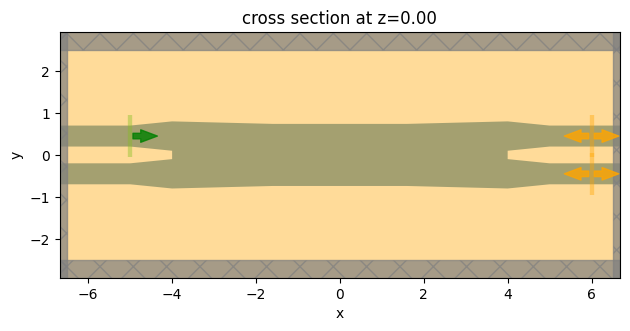

In [7]:
ax = sim.plot(z=0)

Submit the simulation job to the server.

In [8]:
job = web.Job(simulation=sim, task_name="mmi")
sim_data = job.run(path="data/simulation_data.hdf5")

[16:52:12] INFO: Created task 'mmi' with task_id                                    ]8;id=441461;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=713878;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           'fdve-186f6b11-274e-406f-85c4-7ed6388a43d5v1'.                                    

Output()

Output()

[16:52:13] INFO: status = queued                                                    ]8;id=496895;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=688198;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:52:19] INFO: status = preprocess                                                ]8;id=39996;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=597118;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:52:23] INFO: Maximum FlexUnit cost: 0.116. Use 'web.real_cost(task_id)' to get  ]8;id=266856;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=370819;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           the billed FlexUnit cost after a simulation run.                                  

           INFO: starting up solver                                                 ]8;id=441876;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=734028;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: running solver                                                     ]8;id=430101;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=536331;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:53:34] INFO: early shutoff detected, exiting.                                   ]8;id=549166;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=962006;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:53:35] INFO: status = postprocess                                               ]8;id=528429;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=346881;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:53:57] INFO: status = success                                                   ]8;id=466777;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=473237;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:54:09] INFO: loading SimulationData from data/simulation_data.hdf5              ]8;id=131563;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=794655;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

The simulation is complete and the monitor data have been downloaded. First, we plot the field intensity distribution to visualize the power flow. We can observe that the two outputs have a similar intensity.

[16:54:10] WARNING: 'int' field name is deprecated and will be removed in the       ]8;id=996261;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=6320;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           future. Plese use field_name='E' and val='abs^2' for the same effect.             

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

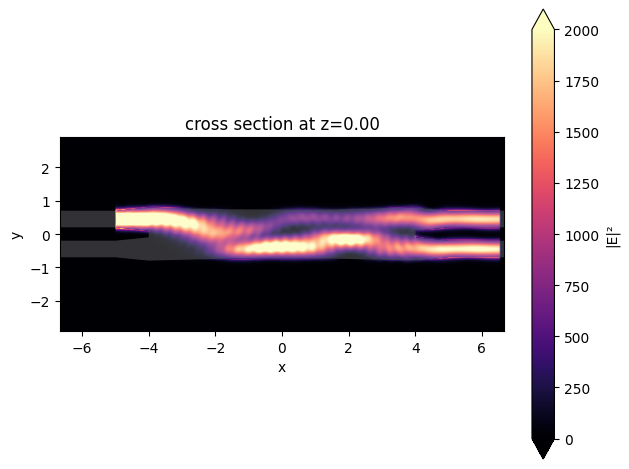

In [9]:
sim_data.plot_field('field','int', vmax=2000);

To quantitatively investigate the power in the two output waveguides, we compute the power from the mode amplitudes. Compared to the simulation results reported in the reference, the small discrepancy here is likely due to the different material properties used.

Ideally, both power levels are 3 dB. Here, we see the through port has a slightly lower power level than the cross port. However, the small difference is acceptable.

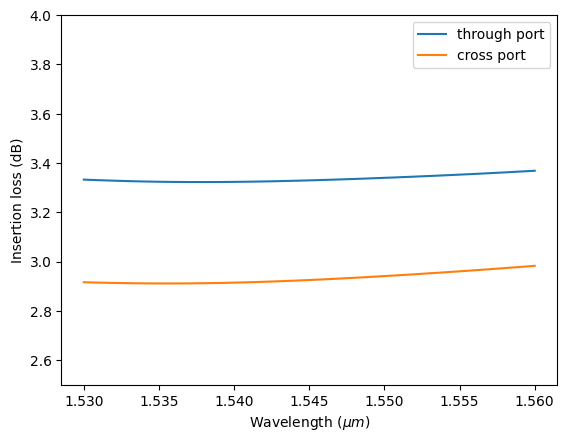

In [10]:
# compute power at the through port
P_through = np.abs(sim_data['through'].amps.sel(direction='+').values)**2 
# compute power at the cross port
P_cross = np.abs(sim_data['cross'].amps.sel(direction='+').values)**2

# plot loss
plt.plot(ldas,-10*np.log10(P_through),label='through port')
plt.plot(ldas,-10*np.log10(P_cross),label='cross port')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Insertion loss (dB)')
plt.ylim(2.5,4)
plt.legend();

Lastly, we check the phase difference in the two outputs. Within the wavelength range, the phase difference is only about 1 degree from the ideal 90 degree.

(85.0, 95.0)

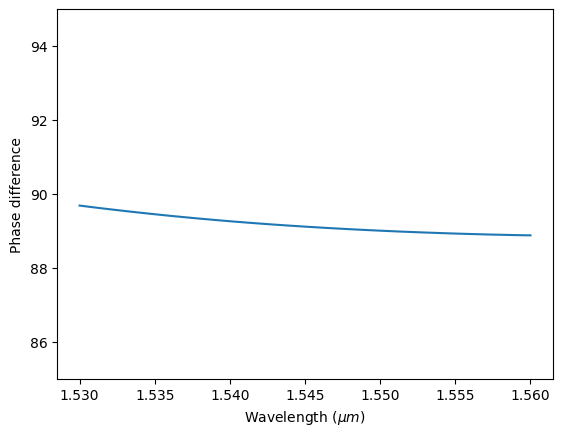

In [11]:
# compute phase at the through port
phase_through = np.angle(sim_data['through'].amps.sel(direction='+').values)
# compute phase at the cross port
phase_cross = np.angle(sim_data['cross'].amps.sel(direction='+').values)
# compute phase difference
delta_phase = (phase_through-phase_cross)*180/np.pi

# plot phase difference
plt.plot(ldas,delta_phase)
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Phase difference')
plt.ylim(85,95);

## Simulation of the Optical Hybrid -- LO Input 

Now that we have tested individual components, we can put them together and simulate the whole device. Again, we directly import the geometry from a stl file.

In [12]:
# import optical hybrid geometry from a stl file
optical_hybrid_geometry = td.TriangleMesh.from_stl(
    filename="misc/optical_hybrid_stl.stl",
)

# define optical hybrid structure
optical_hybrid = td.Structure(geometry=optical_hybrid_geometry, medium=si)

In the first case, define a [ModeSource](../_autosummary/tidy3d.ModeSource.html) at the LO input and four ModeMonitors at the outputs. 

In [13]:
# define a mode source at the LO input waveguide on the top y branch
mode_source_LO = td.ModeSource(
    center=(0, 1, 0),
    size=(2*width, 0, 4*thickness),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
    mode_spec=mode_spec,
    mode_index=0,
)

# define mode monitors at the four output waveguides

mode_monitor_Qn =  td.ModeMonitor(
    center=(-16,-6,0),
    size=(0, 2*width, 4*thickness),
    freqs=freqs,
    name="port_Qn",
    mode_spec=mode_spec,
)

mode_monitor_Qp =  td.ModeMonitor(
    center=(-16,-6.9,0),
    size=(0, 2*width, 4*thickness),
    freqs=freqs,
    name="port_Qp",
    mode_spec=mode_spec,
)


mode_monitor_In =  td.ModeMonitor(
    center=(16,-6,0),
    size=(0, 2*width, 4*thickness),
    freqs=freqs,
    name="port_In",
    mode_spec=mode_spec,
)

mode_monitor_Ip =  td.ModeMonitor(
    center=(16,-6.9,0),
    size=(0, 2*width, 4*thickness),
    freqs=freqs,
    name="port_Ip",
    mode_spec=mode_spec,
)

Define the simulation. 

In [14]:
run_time = 2e-12  #simulation run time

#define simulation
sim = td.Simulation(
        center=(0, -10, 0),
        size=(32,23,10*thickness),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[optical_hybrid],
        sources=[mode_source_LO],
        monitors=[field_monitor, mode_monitor_Qn, mode_monitor_Qp, mode_monitor_In, mode_monitor_Ip],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
        symmetry=(0,0,1)
)


Visualize the simulation.

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

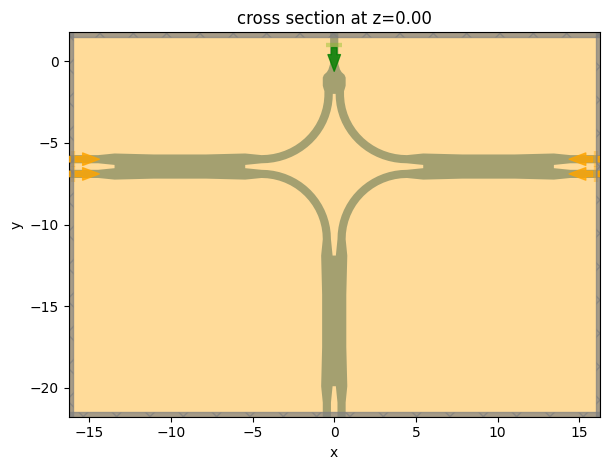

In [15]:
sim.plot(z=0);

Submit the simulation job to the server.

In [16]:
job = web.Job(simulation=sim, task_name="optical_hybrid_lo_input")
sim_data = job.run(path="data/simulation_data.hdf5")

[16:54:13] INFO: Created task 'optical_hybrid_lo_input' with task_id                ]8;id=403426;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=104168;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           'fdve-d9c7f353-5b8b-4699-9f27-eccfcd220817v1'.                                    

Output()

Output()

[16:54:14] INFO: status = queued                                                    ]8;id=100685;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=691156;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:54:21] INFO: status = preprocess                                                ]8;id=204930;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=412044;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:54:26] INFO: Maximum FlexUnit cost: 0.848. Use 'web.real_cost(task_id)' to get  ]8;id=456;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=691078;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           the billed FlexUnit cost after a simulation run.                                  

           INFO: starting up solver                                                 ]8;id=150630;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=870563;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: running solver                                                     ]8;id=520481;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=195526;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:55:41] INFO: early shutoff detected, exiting.                                   ]8;id=337421;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=353360;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: status = postprocess                                               ]8;id=656071;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=589765;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:55:53] INFO: status = success                                                   ]8;id=267311;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=499843;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:55:55] INFO: loading SimulationData from data/simulation_data.hdf5              ]8;id=911769;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=620012;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Visualize the field intensity distribution.

[16:55:57] WARNING: 'int' field name is deprecated and will be removed in the       ]8;id=145885;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=588231;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           future. Plese use field_name='E' and val='abs^2' for the same effect.             

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

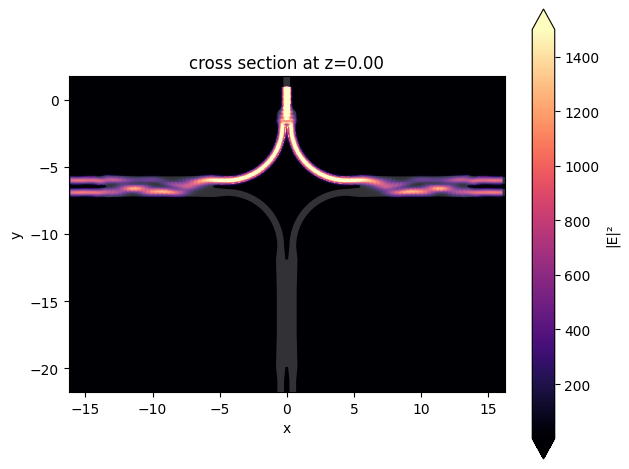

In [17]:
sim_data.plot_field('field','int', vmax=1500);

Besides the error in the relative phase, there are three additional figures of merit (FOM) the characterize the performance of the 90 degree optical hybrid: insertion loss, common mode rejection ratio (CMRR), and imbalance. We define a function to calculate those FOMs and plot the results.

The insertion loss is calculated as $-10log_{10}(P_{tot})$, where $P_{tot}=P_{Ip}+P_{In}+P_{Qp}+P_{Qn}$ is the total power at four output ports.

The CMRR is calculated as CMRR$_I=-20log_{10}(\left|\frac{P_{Ip}-P_{In}}{P_{Ip}+P_{In}}  \right|)$ and CMRR$_Q=-20log_{10}(\left|\frac{P_{Qp}-P_{Qn}}{P_{Qp}+P_{Qn}}  \right|)$.

The imbalance is defined as Imbalance$_I = -10log_{10}(\frac{P_{Ip}}{P_{In}})$ and Imbalance$_Q = -10log_{10}(\frac{P_{Qp}}{P_{Qn}})$.

In [18]:
def calculate_FOM(sim_data):
    # compute power at the Ip port
    P_Ip = np.abs(sim_data['port_Ip'].amps.sel(direction='+').values)**2
    # compute power at the In port
    P_In = np.abs(sim_data['port_In'].amps.sel(direction='+').values)**2
    # compute power at the Qp port
    P_Qp = np.abs(sim_data['port_Qp'].amps.sel(direction='-').values)**2
    # compute power at the Qn port
    P_Qn = np.abs(sim_data['port_Qn'].amps.sel(direction='-').values)**2

    fig, ax = plt.subplots(3,1,tight_layout=True,figsize=(6,10))
    
    # compute and plot insertion loss
    loss = -10*np.log10(P_Ip+P_In+P_Qp+P_Qn)
    ax[0].plot(ldas,loss)
    ax[0].set_xlabel('Wavelength ($\mu m$)')
    ax[0].set_ylabel('Insertion loss (dB)')
    ax[0].set_ylim(0,1)

    # compute and plot CMRR
    CMRR_I = -20*np.log10(np.abs((P_Ip-P_In)/(P_Ip+P_In)))
    CMRR_Q = -20*np.log10(np.abs((P_Qp-P_Qn)/(P_Qp+P_Qn)))
    ax[1].plot(ldas,CMRR_I,label='CMRR$_I$')
    ax[1].plot(ldas,CMRR_Q,label='CMRR$_Q$')
    ax[1].set_xlabel('Wavelength ($\mu m$)')
    ax[1].set_ylabel('CMRR (dB)')
    ax[1].set_ylim(25,45)
    ax[1].legend()

    #compute and plot imbalance
    Imbalance_I = -10*np.log10(P_Ip/P_In)
    Imbalance_Q = -10*np.log10(P_Qp/P_Qn)
    ax[2].plot(ldas,Imbalance_I,label='Imbalance$_I$')
    ax[2].plot(ldas,Imbalance_Q,label='Imbalance$_Q$')
    ax[2].set_xlabel('Wavelength ($\mu m$)')
    ax[2].set_ylabel('Imbalance (dB)')
    ax[2].set_ylim(-0.5,0.5)
    ax[2].legend()
    

Calculate those FOMs and plot the results. Due to symmetry, CMRR$_I$ and CMRR$_Q$ are identical. So is Imbalance$_I$ and Imbalance$_Q$. 

Overall, we see that the design has a good performance. The insertion loss is about 0.3 dB while the CMRRs are above 30 dB and the Imbalances are around 0.1 dB.

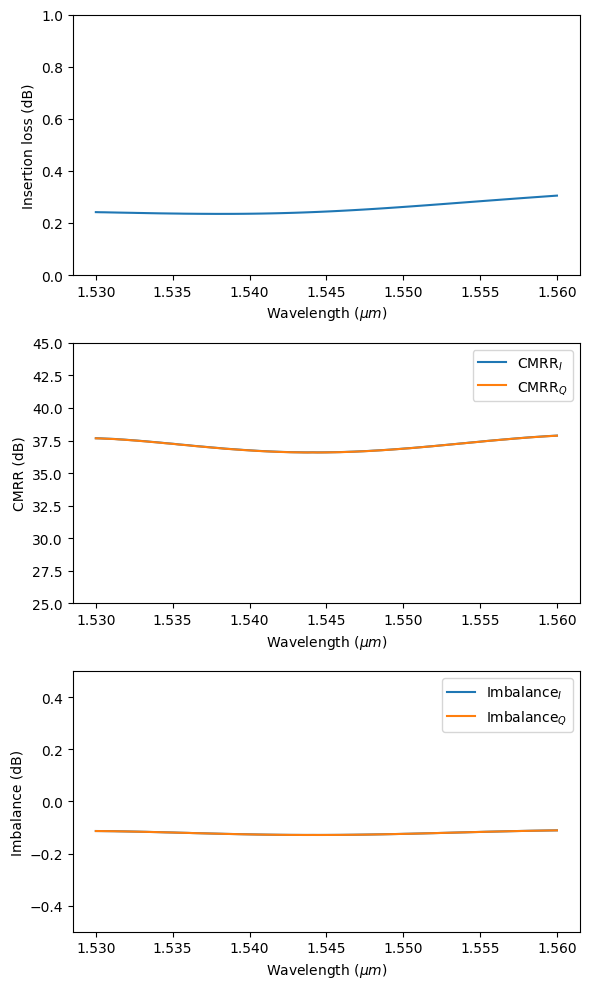

In [19]:
calculate_FOM(sim_data)

## Simulation of the Optical Hybrid -- Signal Input 

Finally, we simulate the case where the input signal is from the bottom signal port. To do so, we only need to define a ModeSource at the signal port and update the previous simulation since other settings of the simulation is identical.

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

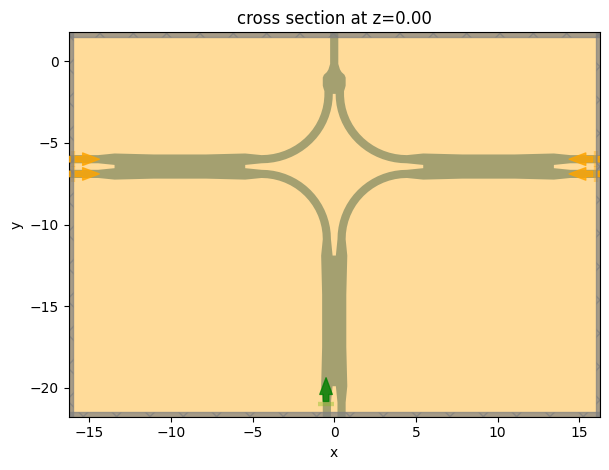

In [20]:
# define a mode source at the signal input waveguide at the bottom MMI
mode_source_signal = td.ModeSource(
    center=(-0.5, -21, 0),
    size=(2*width, 0, 4*thickness),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

#copy simulation and change the source
sim = sim.copy(update={'sources':[mode_source_signal]})
sim.plot(z=0);

In [21]:
job = web.Job(simulation=sim, task_name="optical_hybrid_signal_input")
sim_data = job.run(path="data/simulation_data.hdf5")

[16:56:31] INFO: Created task 'optical_hybrid_signal_input' with task_id            ]8;id=395739;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=145884;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           'fdve-b4508cb9-77d6-4362-b089-2d92e7db1538v1'.                                    

Output()

Output()

[16:56:32] INFO: status = queued                                                    ]8;id=752040;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=929812;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:56:39] INFO: status = preprocess                                                ]8;id=735416;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=686426;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:56:43] INFO: Maximum FlexUnit cost: 0.848. Use 'web.real_cost(task_id)' to get  ]8;id=132560;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=528880;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           the billed FlexUnit cost after a simulation run.                                  

           INFO: starting up solver                                                 ]8;id=100019;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=527811;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: running solver                                                     ]8;id=536131;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=101841;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:57:58] INFO: early shutoff detected, exiting.                                   ]8;id=507399;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=521080;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: status = postprocess                                               ]8;id=16290;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=125791;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:58:10] INFO: status = success                                                   ]8;id=182013;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=117002;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:58:13] INFO: loading SimulationData from data/simulation_data.hdf5              ]8;id=221747;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=56883;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Visualize the field intensity distribution.

[16:58:15] WARNING: 'int' field name is deprecated and will be removed in the       ]8;id=620151;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=246523;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           future. Plese use field_name='E' and val='abs^2' for the same effect.             

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

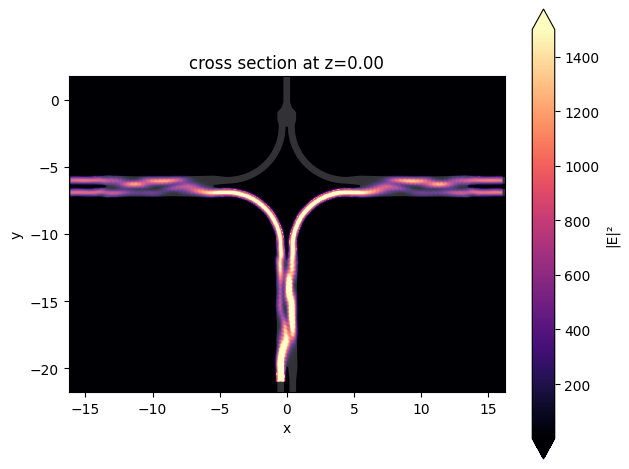

In [22]:
sim_data.plot_field('field','int', vmax=1500);

Calculate those FOMs and plot the results. Since the signal port is the left waveguide of the bottom MMI, CMRR$_I$ and CMRR$_Q$ are expected to be slghtly different. The device performance according to the insertion loss, CMRR, and Imbalance is comparable to the case with input from the LO port. In addition, from the phase simulation, we know the phase error is going to be small too. This means the overall design of the 90 degree optical hybrid works very well.

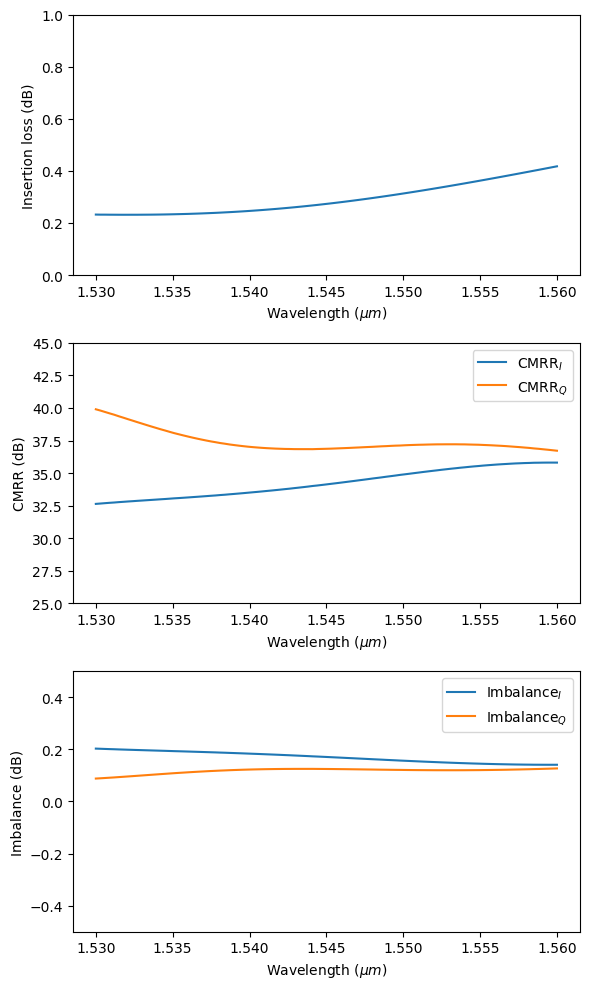

In [23]:
calculate_FOM(sim_data)